In [1]:
# If running Python 2.x, makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting at lower left
%matplotlib inline

from IPython.display import display, Latex, clear_output

In [2]:
import pynrc
from pynrc import nrc_utils          # Variety of useful functions and classes
from pynrc.obs_nircam import obs_hci, nrc_hci # High-contrast imaging observation class

# Disable informational messages and only include warnings and higher
pynrc.setup_logging(level='WARN')

[     pynrc:INFO]   jwst_backgrounds is not installed and will not be used for bg estimates.
pyNRC log messages of level WARN and above will be shown.
pyNRC log outputs will be directed to the screen.


In [3]:
from pynrc.nrc_utils import fourier_imshift, frebin, robust

In [4]:
# Observed spectrum
bp_k = pynrc.bp_2mass('k')
sp = pynrc.stellar_spectrum('A0V', 5.75, 'vegamag', bp_k)

# Circular Masks

In [5]:
mask_arr = ['MASK210R', 'MASK335R', 'MASK430R']
filt_arr = ['F210M',    'F335M',    'F430M']

xmiss = 50
ymiss = 0
xy_offset = [(-15,15), (0,20), (15,15), (-20,0), (0,0), (20,0), (-15,-15), (0,-20), (15,-15)]
rt_offset = [nrc_utils.xy_to_rtheta(x+xmiss, y+ymiss) for x,y in xy_offset]

fov_pix = 128
osamp = 2

In [6]:
nrc_arr = []
for r, th in rt_offset:
    print('{:.1f} ({:.2f}) {:+7.1f}'.format(r, r/1000, th))
    nrc = pynrc.NIRCam(pupil='CIRCLYOT', mask='MASK335R', filter='F335M', ngroup=10,
                       fov_pix=fov_pix, oversample=osamp, #quick=True, force=True, save=False, 
                       offset_r=r/1000., offset_theta=th, include_si_wfe=True)#,
#                        opd = ('OPD_RevW_ote_for_NIRCam_requirements.fits.gz', 5))
    
    nrc_arr.append(nrc)

38.1 (0.04)   -66.8
53.9 (0.05)   -68.2
66.7 (0.07)   -77.0
30.0 (0.03)   -90.0
50.0 (0.05)   -90.0
70.0 (0.07)   -90.0
38.1 (0.04)  -113.2
53.9 (0.05)  -111.8
66.7 (0.07)  -103.0


In [18]:
# Generate PSFs for each position
slope_ideal = []
slope_ideal_osamp = []
slope_noise = []
ng_good_arr = []

for i, nrc in enumerate(nrc_arr):
    print(i)
    pixscale = nrc.pixelscale
    pixscale_over = pixscale / osamp    
    
    # Get oversampled PSF
    _, psf_osamp = nrc.gen_psf(sp=sp, return_oversample=True)
    
    # Shift back to center position
    xoff, yoff = xy_offset[i]
    xoff = xoff / (pixscale_over * 1000)
    yoff = yoff / (pixscale_over * 1000)
    psf_osamp = fourier_imshift(psf_osamp, -xoff, -yoff, pad=True)
    
    # Rebin PSF to detector pixels
    psf = frebin(psf_osamp, dimensions=fov_pix)

    # Determine group at which each pixel saturates
    t_group = nrc.multiaccum_times['t_group']
    t_int = nrc.multiaccum_times['t_int']
    ng = nrc.multiaccum.ngroup
    sat_vals = nrc.saturation_levels(sp, image=psf)
    sat_ng = ((t_int / t_group) / sat_vals).astype(int)
    sat_ng[sat_ng>ng] = ng
    
    # Add noise
    det = nrc.Detectors[0]
    im_noise = det.pixel_noise(fsrc=psf, fzodi=nrc.bg_zodi(), ng=sat_ng, ideal_Poisson=True)
    im_final = psf + np.random.normal(scale=im_noise)
    
    slope_ideal.append(psf)
    slope_ideal_osamp.append(psf_osamp)
    slope_noise.append(im_final)
    ng_good_arr.append(sat_ng)

slope_ideal = np.array(slope_ideal)
slope_ideal_osamp = np.array(slope_ideal_osamp)
slope_noise = np.array(slope_noise)
ng_good_arr = np.array(ng_good_arr)

# psf_arr = np.array([nrc.gen_psf(return_oversample=True)[1] for nrc in nrc_arr])
# # Generate noise for each obs
# noise_arr = np.array([nrc.gen_psf(return_oversample=True)[1] for nrc in nrc_arr])

0
1
2
3
4
5
6
7
8


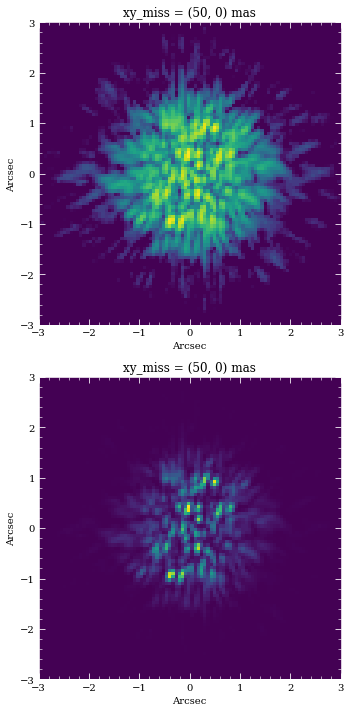

In [19]:
from matplotlib.colors import LogNorm

fig, axes = plt.subplots(2,1, figsize=(5,10))

xylim = np.array([-1,1])*3
pixscale = nrc.pixelscale
pixscale_over = nrc.pixelscale / osamp



for i, ax in enumerate(axes):
    im = slope_noise[4].copy()
    vmin = 1
    vmax = im.max()
    im[im<vmin] = vmin
    
    norm_list = [LogNorm(vmin=im.min(), vmax=im.max()), None]
    norm = norm_list[i]
    extent = np.array([-1,1,-1,1]) * pixscale * im.shape[0] / 2
    ax.imshow(im, extent=extent, norm=norm)

    ax.set_xlim(xylim)
    ax.set_ylim(xylim)

    ax.set_xlabel('Arcsec')
    ax.set_ylabel('Arcsec')
    ax.set_title('xy_miss = ({}, {}) mas'.format(xmiss,ymiss))

    ax.xaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])
    ax.yaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])

    ax.tick_params(axis='both', color='white', which='both')
    for k in ax.spines.keys():
        ax.spines[k].set_color('white')


fig.tight_layout()

In [21]:
diff_arr = slope_noise - slope_noise[4]

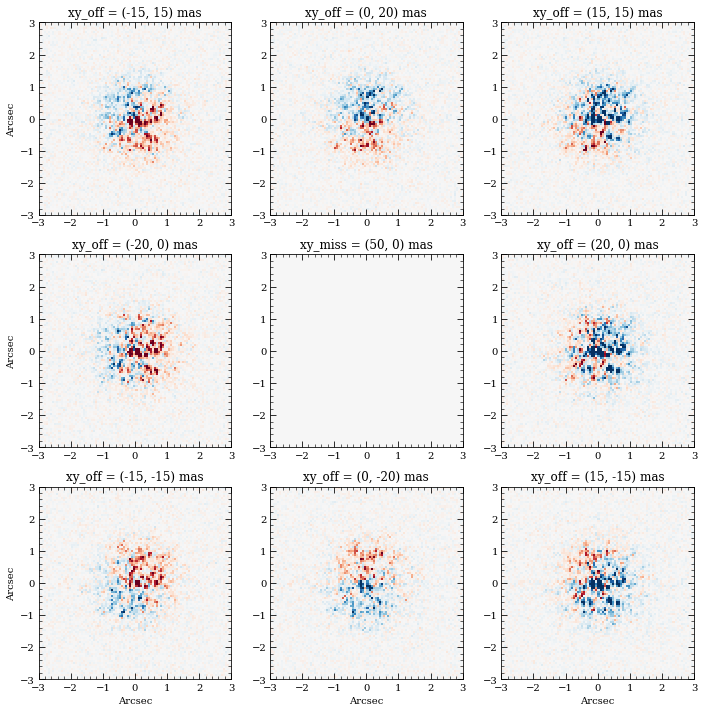

In [22]:
fig, axes = plt.subplots(3,3, figsize=(10,10))
axes = axes.flatten()

im = diff_arr[0]
vmin, vmax = np.array([-1,1]) * np.max(np.abs(im)) * 0.3
xylim = np.array([-1,1])*3
for i, ax in enumerate(axes):
    im = diff_arr[i]
    
    
    extent = np.array([-1,1,-1,1]) * pixscale * im.shape[0] / 2
    ax.imshow(im, vmin=vmin, vmax=vmax, extent=extent, cmap='RdBu')
    
    if i==4:
        ax.set_title('xy_miss = ({}, {}) mas'.format(xmiss,ymiss))
    else:
        ax.set_title('xy_off = {} mas'.format(xy_offset[i]))

        
    
    ax.set_xlim(xylim)
    ax.set_ylim(xylim)
    
    if i>5: ax.set_xlabel('Arcsec')
    if np.mod(i,3)==0: ax.set_ylabel('Arcsec')


    fig.tight_layout()

In [46]:
rdist = nrc_utils.dist_image(slope_ideal[0], pixscale=pixscale)
ind = rdist<1

# Left/Right ratios
for i in range(3):
    print(np.median(slope_noise[2+i*3][ind] / slope_noise[0+i*3][ind]))
    
# Top/Bottom ratios
for i in range(3):
    print(np.median(slope_noise[i][ind] / slope_noise[6+i][ind]))

1.0266946939842208
1.0333476542893925
1.0244657259426226
1.000709186582066
1.0054940543704318
1.004644630596831


0.9791115054483701
0.9690238557334494
0.9797581641674129


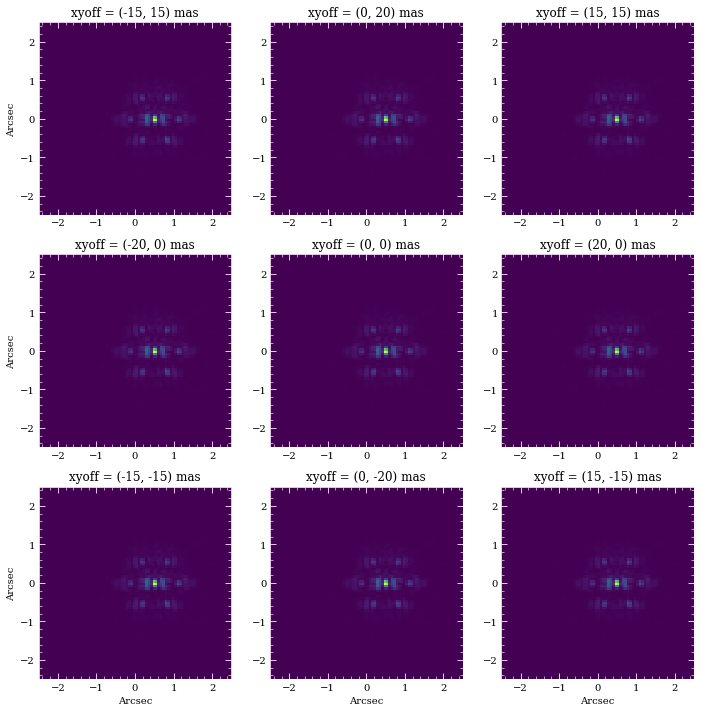

In [11]:
fig, axes = plt.subplots(3,3, figsize=(10,10))
axes = axes.flatten()

xylim = np.array([-1,1])*2.5
pixscale = nrc.pixelscale
pixscale_over = nrc.pixelscale / osamp
for i, ax in enumerate(axes):
    im = slope_noise[i]
    extent = np.array([-1,1,-1,1]) * pixscale * im.shape[0] / 2
    ax.imshow(im, extent=extent)
    
    ax.set_title('xyoff = {} mas'.format(xy_offset[i]))
    
    ax.set_xlim(xylim)
    ax.set_ylim(xylim)
    
    if i>5: ax.set_xlabel('Arcsec')
    if np.mod(i,3)==0: ax.set_ylabel('Arcsec')

    ax.xaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])
    ax.yaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])
    
    ax.tick_params(axis='both', color='white', which='both')
    for k in ax.spines.keys():
        ax.spines[k].set_color('white')

    
fig.tight_layout()

In [8]:
psf_mean = np.mean(psf_arr, axis=0)
psf_resid0 = psf_arr - psf_arr[4]

psf_resid = []
for i, psf in enumerate(psf_arr):
    diff0 = psf - psf_arr[4]

    xoff, yoff = xy_offset[i]
    xoff = xoff / (pixscale_over * 1000)
    yoff = yoff / (pixscale_over * 1000)
    
    psf = nrc_utils.fourier_imshift(psf, -xoff, -yoff, pad=True)
    diff = psf - psf_arr[4]
    
    psf_resid.append(diff)
    
    diff0_rebin = nrc_utils.frebin(diff0, dimensions=fov_pix)
    diff_rebin = nrc_utils.frebin(diff, dimensions=fov_pix)
    print('({:.2f} {:.2f}) {} {} {}'.format(xoff, yoff, np.max(np.abs(diff_rebin))/np.sum(psf), 
                                         np.max(np.abs(diff0_rebin))/np.sum(psf), np.sum(psf)))
    
psf_resid = np.array(psf_resid)

(-0.48 0.48) 0.0002520084558456533 0.0010289498947633213 0.0019673429869642217
(0.00 0.63) 0.00015127835941124065 0.0006776391981150119 0.001960916856600509
(0.48 0.48) 0.00011678780105237613 0.0007564620970214326 0.001955558434783458
(-0.63 0.00) 0.00025497974700156245 0.001048082193041795 0.0019668497265588414
(0.00 0.00) 8.131382858863991e-19 0.0 0.0019531570504893107
(0.63 0.00) 0.00014173570182100537 0.0009784825980588114 0.0019522229240911593
(-0.48 -0.48) 0.00023185089572579898 0.0008430104244355921 0.001963568608679604
(0.00 -0.63) 0.00018938471297771584 0.0006999276416966455 0.001956885448559211
(0.48 -0.48) 0.00020780746751972246 0.0008781991081041945 0.0019533074487906757


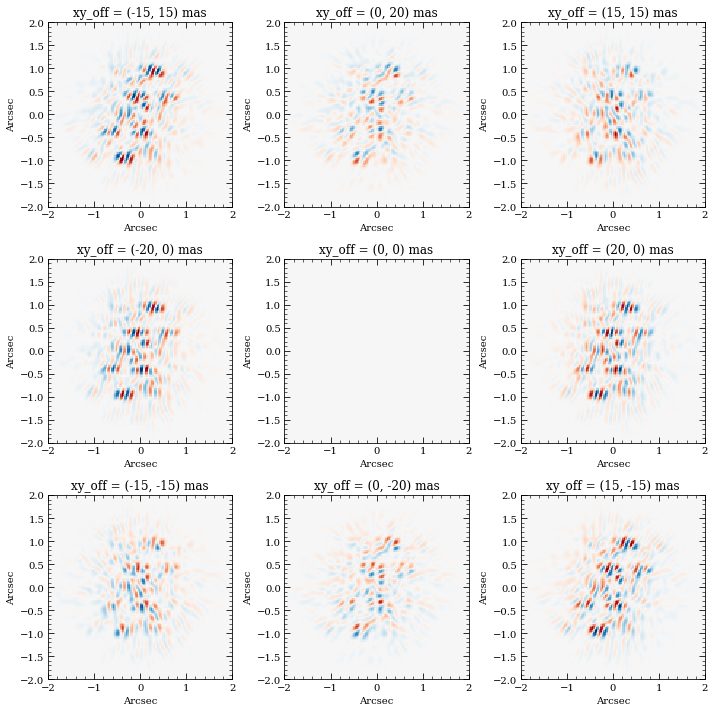

In [9]:
fig, axes = plt.subplots(3,3, figsize=(10,10))
axes = axes.flatten()


im = psf_resid0[0]
vmin, vmax = np.array([-1,1]) * np.max(np.abs(im)) * 0.9
xylim = np.array([-1,1])*2
for i, ax in enumerate(axes):
    im = psf_resid0[i]
    
    
    extent = np.array([-1,1,-1,1]) * pixscale_over * im.shape[0] / 2
    ax.imshow(im, vmin=vmin, vmax=vmax, extent=extent, cmap='RdBu')
    
    ax.set_title('xy_off = {} mas'.format(xy_offset[i]))
    
    ax.set_xlim(xylim)
    ax.set_ylim(xylim)
    
    ax.set_xlabel('Arcsec')
    ax.set_ylabel('Arcsec')

fig.tight_layout()

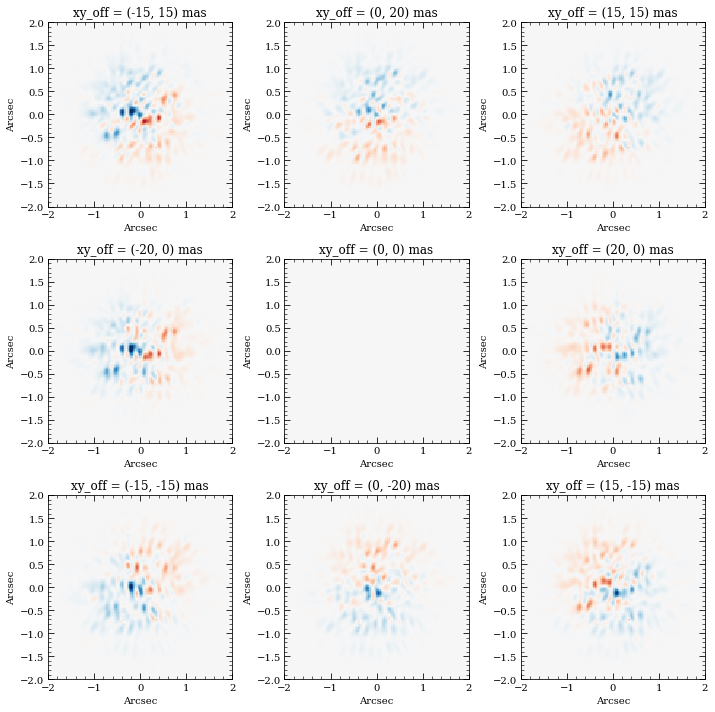

In [10]:
fig, axes = plt.subplots(3,3, figsize=(10,10))
axes = axes.flatten()


im = psf_resid[0]
vmin, vmax = np.array([-1,1]) * np.max(np.abs(im)) * 0.9
xylim = np.array([-1,1])*2
for i, ax in enumerate(axes):
    im = psf_resid[i]
    
    
    extent = np.array([-1,1,-1,1]) * pixscale_over * im.shape[0] / 2
    ax.imshow(im, vmin=vmin, vmax=vmax, extent=extent, cmap='RdBu')
    
    ax.set_title('xy_off = {} mas'.format(xy_offset[i]))
    
    ax.set_xlim(xylim)
    ax.set_ylim(xylim)
    
    ax.set_xlabel('Arcsec')
    ax.set_ylabel('Arcsec')

fig.tight_layout()

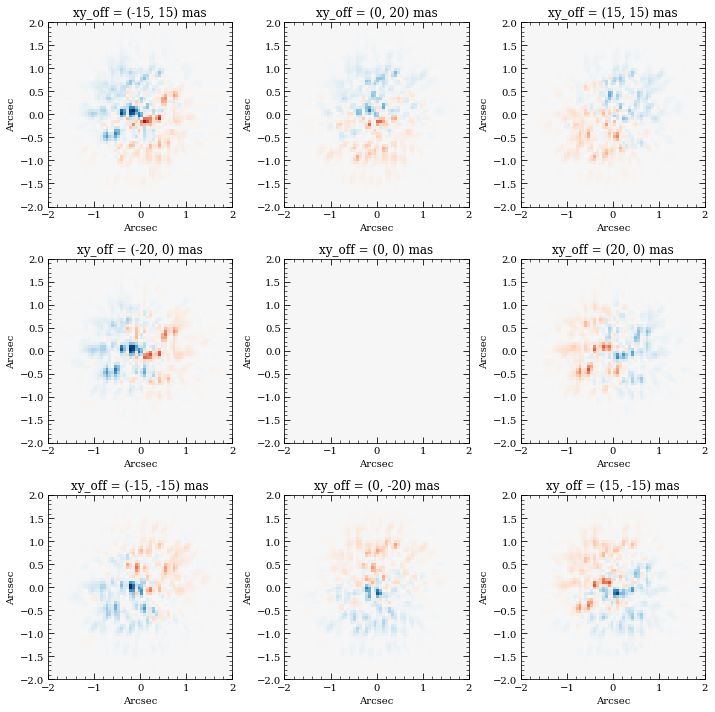

In [11]:
fig, axes = plt.subplots(3,3, figsize=(10,10))
axes = axes.flatten()


im = nrc_utils.frebin(psf_resid[0], dimensions=fov_pix)
vmin, vmax = np.array([-1,1]) * np.max(np.abs(im)) * 0.9
xylim = np.array([-1,1])*2
for i, ax in enumerate(axes):
    im = nrc_utils.frebin(psf_resid[i], dimensions=fov_pix)
    extent = np.array([-1,1,-1,1]) * pixscale * im.shape[0] / 2
    ax.imshow(im, vmin=vmin, vmax=vmax, extent=extent, cmap='RdBu')
    
    ax.set_title('xy_off = {} mas'.format(xy_offset[i]))
    
    ax.set_xlim(xylim)
    ax.set_ylim(xylim)
    
    ax.set_xlabel('Arcsec')
    ax.set_ylabel('Arcsec')

fig.tight_layout()

In [17]:
psf_sum = np.array([psf.sum() for psf in psf_arr])
psf_max = np.array([psf.max() for psf in psf_arr])
for psf in psf_arr:
    print(psf.max(), psf.sum())

7.04058404987797e-06 0.001967603026469025
7.297607808031373e-06 0.001961071218375933
7.5450162884250026e-06 0.0019557897706808393
7.107390680762913e-06 0.0019670158393672588
7.177567160167211e-06 0.0019531969130472445
7.688729622206375e-06 0.001952385116473933
6.881925491147903e-06 0.0019638088850442255
7.42909990520065e-06 0.001957068839882334
7.429321020144705e-06 0.0019535339781857697


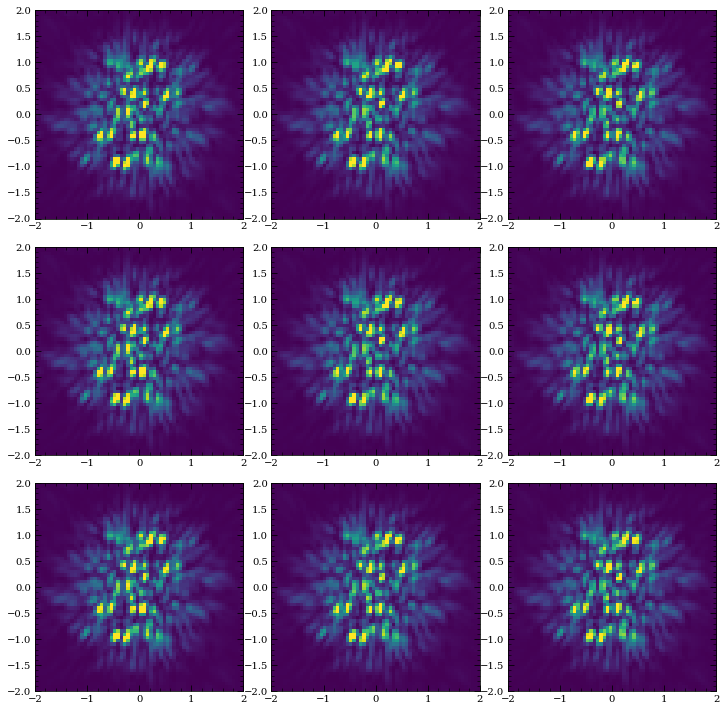

In [50]:
fig, axes = plt.subplots(3,3, figsize=(10,10))
axes = axes.flatten()

sig = np.std(psf_arr[0])
for i, ax in enumerate(axes):
    im = psf_arr[i]
    extent = np.array([-1,1,-1,1]) * nrc.pixelscale * im.shape[0] / 2
    ax.imshow(im, vmin=0, vmax=10*sig, extent=extent)
    
    ax.set_xlim(-2,2)
    ax.set_ylim(-2,2)

fig.tight_layout()

In [71]:
psf_mean = np.mean(psf_arr, axis=0)
psf_resid = psf_arr - psf_arr[4]

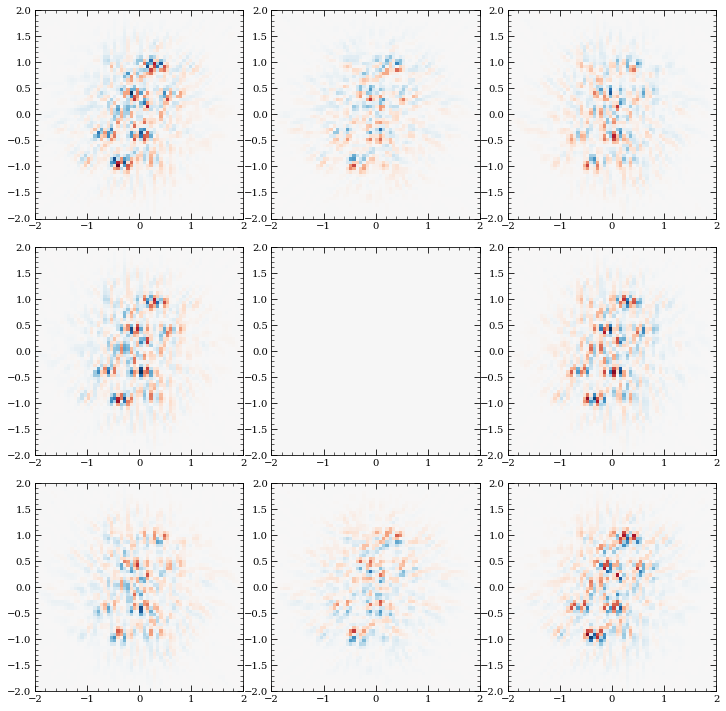

In [72]:
fig, axes = plt.subplots(3,3, figsize=(10,10))
axes = axes.flatten()

vmin, vmax = np.array([-1,1]) * np.max(np.abs(psf_resid)) * 0.9
for i, ax in enumerate(axes):
    im = psf_resid[i]
    extent = np.array([-1,1,-1,1]) * nrc.pixelscale * im.shape[0] / 2
    ax.imshow(im, vmin=vmin, vmax=vmax, extent=extent, cmap='RdBu')
    
    ax.set_xlim(-2,2)
    ax.set_ylim(-2,2)

fig.tight_layout()

In [8]:
nrc0 = nrc_hci(pupil='CIRCLYOT', mask='MASK335R', filter='F335M', ngroup=10,
               quick=True, force=True, save=False, fov_pix=128)

In [43]:
psf0_arr = np.array([nrc0.gen_offset_psf(r/1000, th) for r,th in rt_offset])

In [44]:
psf0_mean = np.mean(psf0_arr, axis=0)
psf0_resid = psf0_arr - psf0_mean

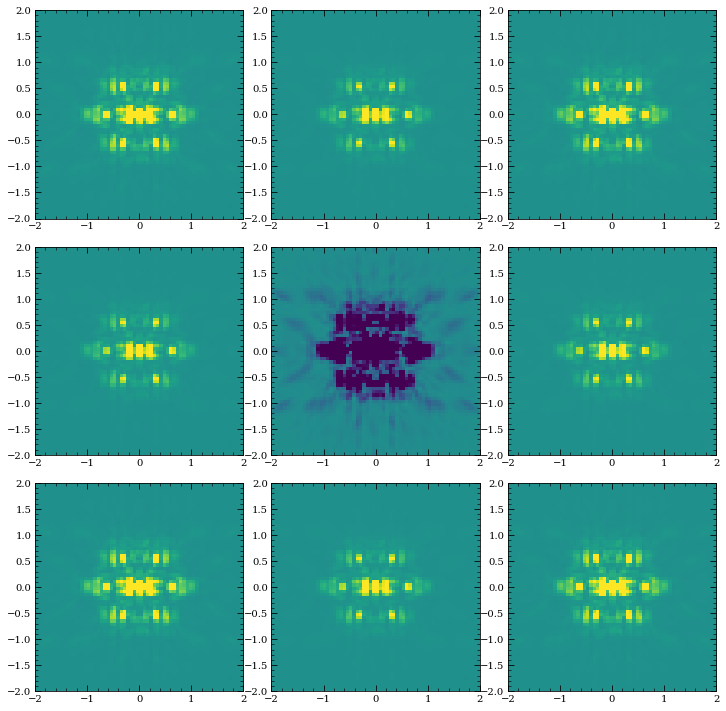

In [46]:
fig, axes = plt.subplots(3,3, figsize=(10,10))
axes = axes.flatten()

sig = np.std(psf0_resid[0])
for i, ax in enumerate(axes):
    im = psf0_resid[i]
    extent = np.array([-1,1,-1,1]) * nrc.pixelscale * im.shape[0] / 2
    ax.imshow(im, vmin=-5*sig, vmax=5*sig, extent=extent)
    
    ax.set_xlim(-2,2)
    ax.set_ylim(-2,2)

fig.tight_layout()

In [9]:
for r, th in rt_offset:
    psf = nrc0.gen_offset_psf(r/1000, th)
    print(psf.max(), psf.sum())

7.177573340974739e-06 0.001954064568410739
7.177572987488432e-06 0.0019540149463689238
7.177573340974739e-06 0.001954064568410739
7.177572987488432e-06 0.0019540149463689238
7.177567160167211e-06 0.0019531969130472445
7.177572987488432e-06 0.0019540149463689238
7.177573340974739e-06 0.001954064568410739
7.177572987488432e-06 0.0019540149463689238
7.177573340974739e-06 0.001954064568410739


In [46]:
psf0.sum()

0.001961071218375933

In [42]:
psf = nrc.gen_offset_psf(0.1,0)
print(psf.sum())

0.0020934938050585893


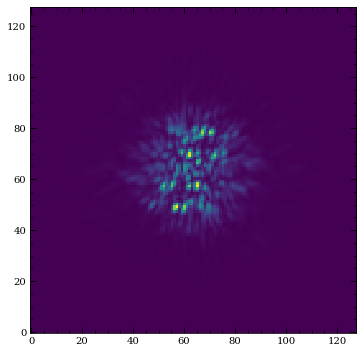

In [35]:
plt.imshow(psf)